In [21]:
import os
import importlib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from customer_segmentation.utils import functions

importlib.reload(functions)

# Set pandas to display all columns
pd.set_option("display.max_columns", None)

In [39]:
# import data
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
file_name = "cohort_data.csv"
file_path = os.path.join(data_dir, file_name)

cohort = pd.read_csv(file_path)

### **Preprocessing**

In [40]:
# convert data & seperate binary and numeric values

cohort["user_id"] = cohort["user_id"].astype(str)
# get binary and numeric values
binary_cols = functions.get_binary_columns(cohort)
numeric_cols = cohort.select_dtypes(include=[np.number]).columns.to_list()

**Select features for scaling & PCA**

In [62]:
feature_groups = {
    "discount_score": [
        "total_discount_rate",
        "avg_flight_discount",
        "avg_hotel_discount",
        "flight_discount_rate",
        "hotel_discount_rate",
        "discount_per_km",
    ],
    "user_score": ["age", "is_married", "has_children"],   
    "booking_score": ["trips_per_month", "flight_booked", "hotel_booked"],
    "engagement_score": [
        "days_last_trip",
        "sessions_per_month",
        "avg_session_duration_seconds",
        "month_active",
    ],
    "travel_score": [
        "avg_diff_trip_days",
        "avg_days_advance_booking",
        "avg_travel_days",
        "avg_seats",
        "avg_checked_bags",
        "avg_flight_travel_days",
        "avg_distance_km",
        "avg_rooms",
        "avg_hotel_nights",
    ],
    "spending_score": ["avg_booking_value"],   
    "cancellation_score": ["cancellation_rate"],
}

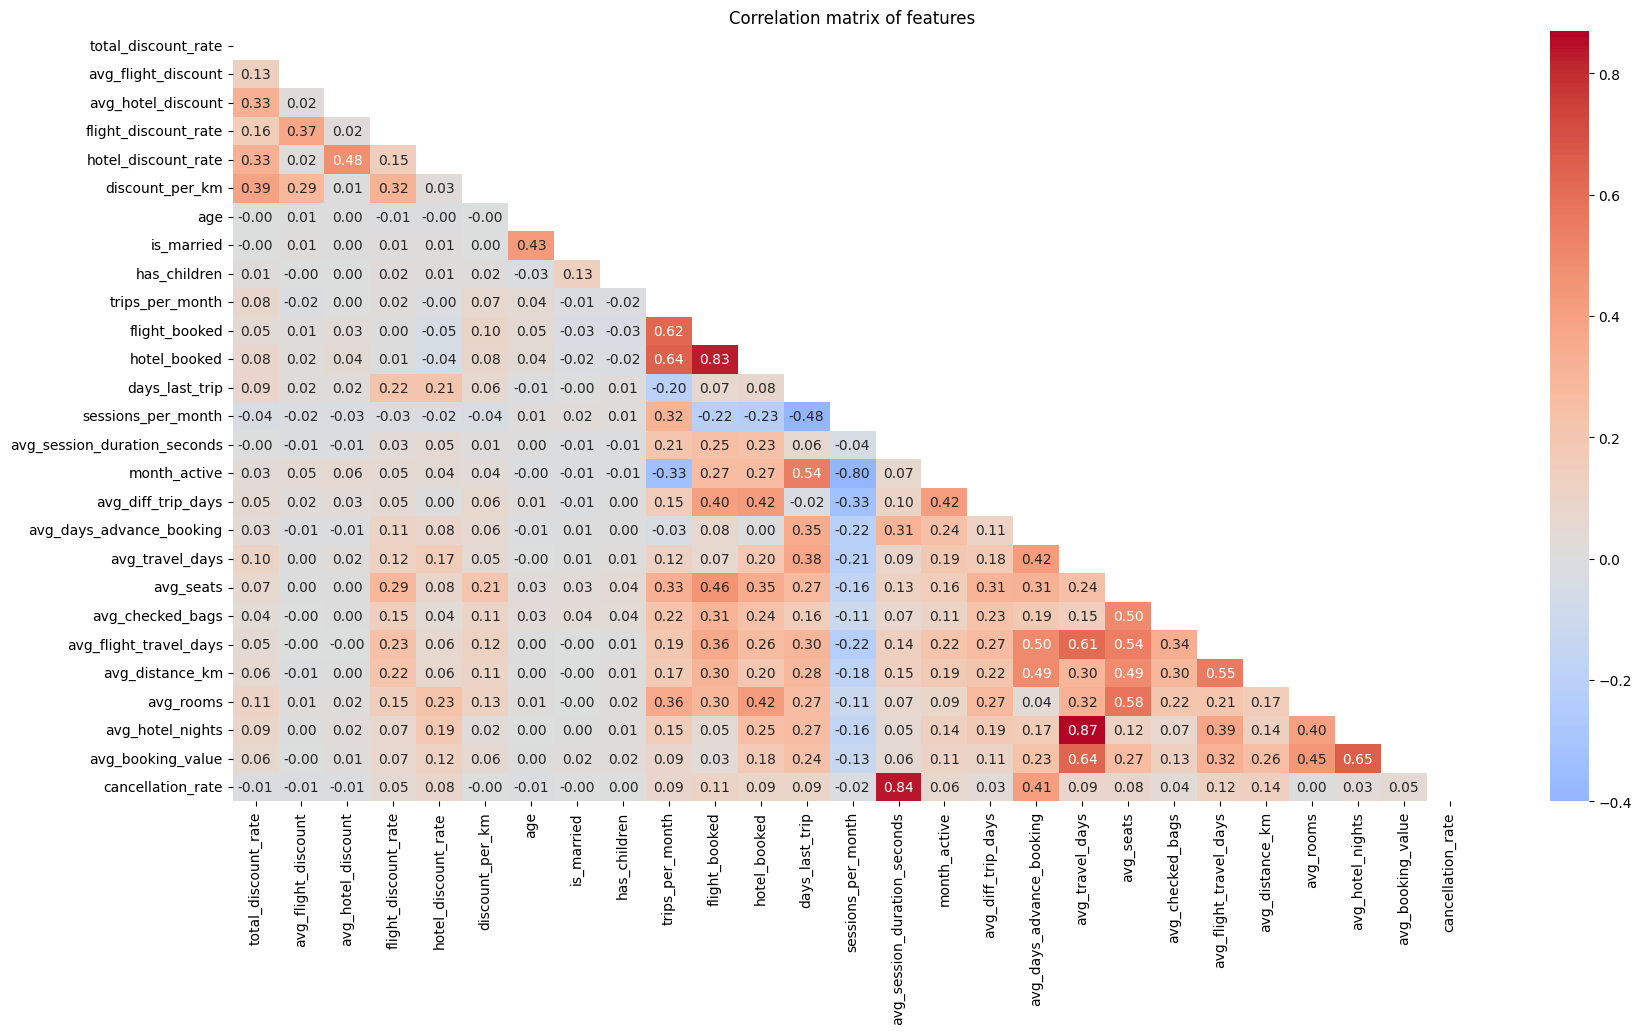

In [63]:
metrics = [m for k, metric in feature_groups.items() for m in metric]

matrix = np.triu(cohort[metrics].corr())
plt.figure(figsize=(20, 10))
plt.title('Correlation matrix of features', fontsize=12)
sns.heatmap(cohort[metrics].corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-0.4, center=0, mask=matrix)
plt.show()

**Apply PCA per thematic groups**

In [64]:
for score_name, features in feature_groups.items():
    cohort = functions.PCA_pipeline(df=cohort, features=features, score_name=score_name)


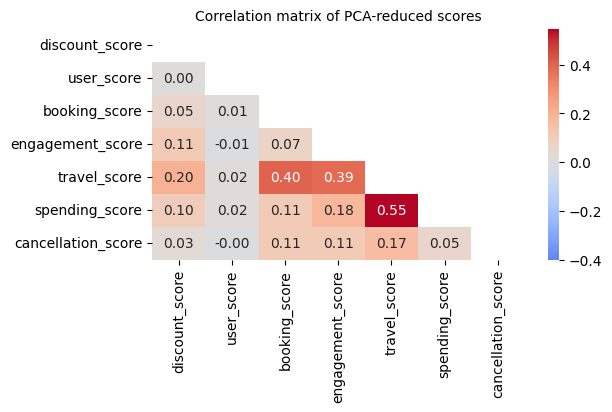

In [65]:
scores = [k for k in feature_groups.keys()]

matrix = np.triu(cohort[scores].corr())
plt.figure(figsize=(6, 3))
plt.title('Correlation matrix of PCA-reduced scores', fontsize=10)
sns.heatmap(cohort[scores].corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-0.4, center=0, mask=matrix)
plt.show()

### **Clustering**

**Extract scores for clustering**

In [66]:
X = cohort[scores]

**Apply elbow-method to find k number of cluster**

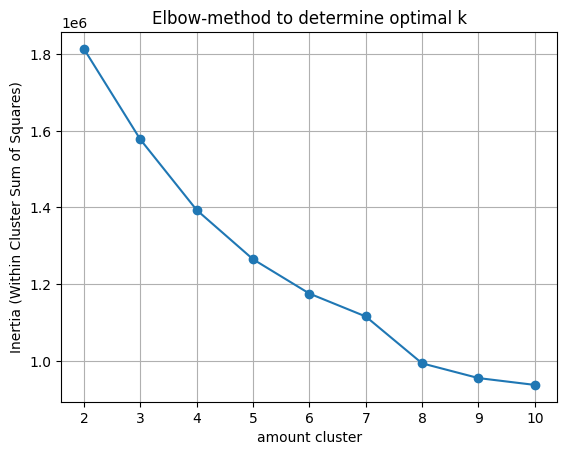

In [67]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, "o-")
plt.xlabel("amount cluster")
plt.ylabel("Inertia (Within Cluster Sum of Squares)")
plt.title("Elbow-method to determine optimal k")
plt.grid(True)
plt.show()

**Apply kmeans clustering**

In [68]:
kmeans = KMeans(n_clusters=7, random_state=42, n_init="auto")
cohort["cluster"] = kmeans.fit_predict(X)

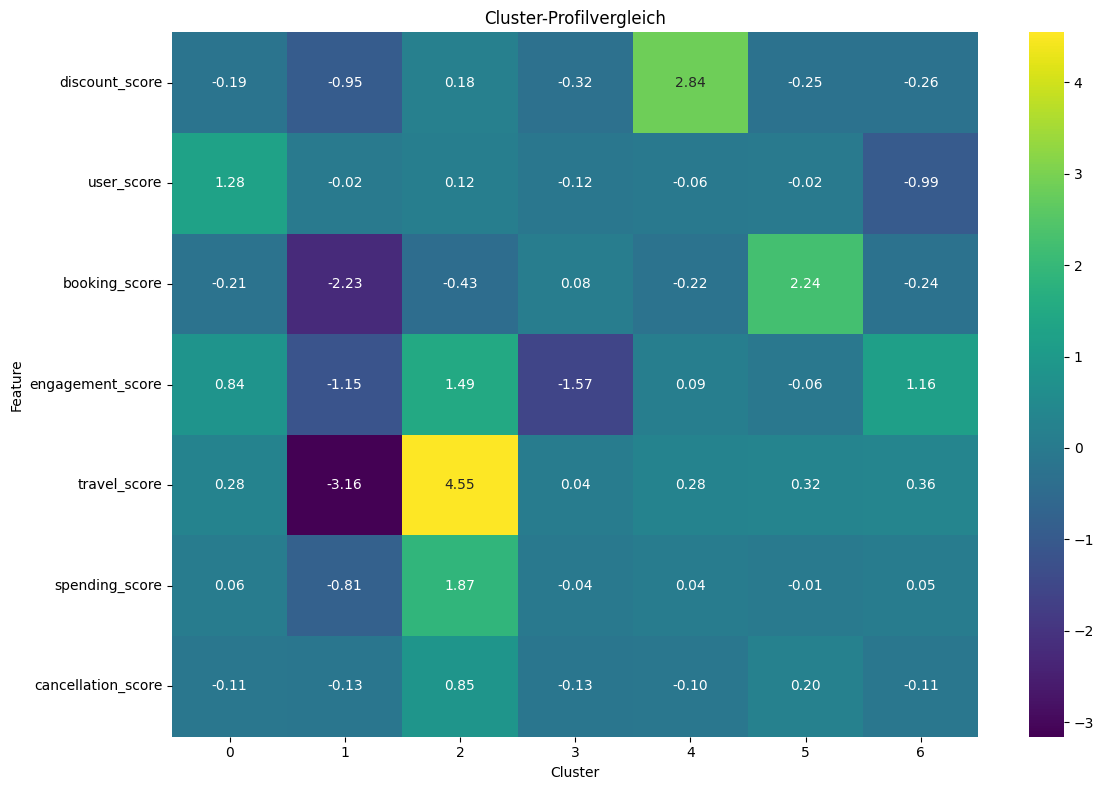

In [69]:
# mean values per cluster
cluster_profiles = cohort.groupby("cluster")[scores].mean()

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles.T, cmap="viridis", annot=True, fmt=".2f")
plt.title("Cluster-Profilvergleich")
plt.ylabel("Feature")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

**Labeling cluster in data frame**

In [ ]:
cluster_labels = {
    0: "",
    1: "Balanced User",
    2: "Frequent Traveller with Low Discount Usage",
    3: "Balanced User",
    4: "Price-sensitive User",
    5: "Balanced User",
    6: "Balanced User",
}
cohort["cluster_label"] = cohort["cluster"].map(cluster_labels)
